# 1. Configuración del Entorno y Librerías

Iniciamos el entorno de trabajo importando las herramientas necesarias para la etapa de modelado:
* **Pandas/Numpy:** Manipulación de datos.
* **Scikit-Learn:** Nuestra suite principal para Machine Learning (Modelos, Métricas y Preprocesamiento).
* **Seaborn/Matplotlib:** Para visualizar el rendimiento de los modelos.

In [31]:
#  IMPORTACIÓN DE LIBRERÍAS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Herramientas de Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Configuración visual
sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.2f' % x)

print("✅ Librerías de Machine Learning cargadas correctamente.")

✅ Librerías de Machine Learning cargadas correctamente.


# 2. Carga del Dataset Procesado

Recuperamos el archivo `03_inmuebles_procesado_final.csv` generado en la etapa anterior (EDA). Este dataset ya se encuentra limpio, imputado y codificado, listo para ser consumido por los algoritmos.

In [32]:
# 2. CARGA DE DATOS

# Ajusta la ruta si es necesario, debe ser la misma donde guardaste el archivo anterior
ruta_archivo = 'C:\\Users\\PC\\Desktop\\DataScience-Inmuebles\\data\\03_inmuebles_procesado_final.csv'

try:
    df = pd.read_csv(ruta_archivo)
    print(f"✅ Datos cargados exitosamente.")
    print(f"   -> Dimensiones: {df.shape[0]:,} filas x {df.shape[1]} columnas")
    
    # Verificación rápida
    display(df.head(3))
except FileNotFoundError:
    print("❌ Error Crítico: No se encuentra el archivo procesado. Ejecuta primero el notebook de EDA.")

✅ Datos cargados exitosamente.
   -> Dimensiones: 12,787 filas x 69 columnas


,precio_venta_usd,precio_expensas,ambientes,baños,dormitorios,sup_cubierta,cocheras,apto_mascotas,apto_profesional,precio_m2,...,orientacion_noroeste,orientacion_norte,orientacion_oeste,orientacion_sur,orientacion_sureste,orientacion_suroeste,estado_a refaccionar,estado_bueno,estado_excelente,estado_muy bueno
0,75000.00,32000.00,3.00,1.00,2.00,60.00,0.00,0.00,0.00,1250.00,...,False,False,False,False,False,False,False,False,False,False
1,115000.00,5000.00,3.00,1.00,2.00,52.00,0.00,0.00,0.00,2211.54,...,False,False,False,False,False,False,False,False,False,False
2,55000.00,46000.00,2.00,1.00,1.00,30.00,0.00,0.00,0.00,1833.33,...,False,True,False,False,False,False,False,False,False,False


# 3. División del Dataset (Train / Test Split)

Para evaluar correctamente el rendimiento de nuestros modelos y evitar el *Overfitting* (memorización), dividimos los datos en dos conjuntos:

1.  **Set de Entrenamiento (Train - 80%):** Datos que el modelo utilizará para aprender patrones.
2.  **Set de Prueba (Test - 20%):** Datos ocultos que usaremos para "tomarle examen" al modelo final.

**Nota Importante:** Eliminamos la variable `precio_m2` del set de entrenamiento. Esta variable fue creada usando el precio de venta (Target), por lo que incluirla sería hacer trampa (**Data Leakage**).

In [33]:
# 3. PREPARACIÓN DE DATOS (SPLIT)

print("\n DIVIDIENDO DATOS PARA ENTRENAMIENTO ")

# 1. Definir Features (X) y Target (y)
# X: Todas las variables MENOS el precio y el precio_m2 (Data Leakage)
X = df.drop(['precio_venta_usd', 'precio_m2'], axis=1)

# y: Lo que queremos predecir
y = df['precio_venta_usd']

# 2. Ejecutar el Split (80/20)
# random_state=42 asegura que si corremos esto mañana, la división sea idéntica
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"✅ División completada:")
print(f"   -> Entrenamiento (X_train): {X_train.shape[0]:,} filas (Para estudiar)")
print(f"   -> Prueba (X_test):          {X_test.shape[0]:,} filas (Para el examen)")
print(f"   -> Cantidad de Variables:    {X_train.shape[1]} columnas")


 DIVIDIENDO DATOS PARA ENTRENAMIENTO 
✅ División completada:
   -> Entrenamiento (X_train): 10,229 filas (Para estudiar)
   -> Prueba (X_test):          2,558 filas (Para el examen)
   -> Cantidad de Variables:    67 columnas


# 4. Selección de Modelos (Torneo de Algoritmos)

Para determinar qué enfoque predice mejor los precios, sometemos a prueba tres familias de algoritmos con diferentes niveles de complejidad:

1.  **Regresión Lineal (Baseline):** El modelo más simple. Asume que el precio sube proporcionalmente de forma recta. Sirve como línea base: si un modelo complejo no supera a este, no vale la pena usarlo.
2.  **Árbol de Decisión (Decision Tree):** Modelo no lineal que toma decisiones en cascada (ej: "Si es Palermo y tiene > 100m², entonces vale X"). Captura mejor las reglas del mercado pero tiende a memorizar (overfitting).
3.  **Random Forest (Ensemble):** Combina cientos de árboles de decisión para reducir el error y la varianza. Es el estándar de oro en la industria para datos tabulares complejos.

**Métricas de Evaluación:**
* **$R^2$ Score (Coeficiente de Determinación):** Indica qué porcentaje de la variación del precio es capaz de explicar nuestro modelo. (1.0 es perfecto, 0.0 es inútil).
* **MAE (Error Absoluto Medio):** Mide el error promedio en dólares. Es la métrica preferida por el negocio porque es fácil de interpretar: *"En promedio, el modelo se equivoca por X dólares"*.

--- INICIANDO RENDIMIENTO DE MODELOS ---

Entrenando: Regresión Lineal...
   -> R2 Score: 0.7168
   -> Error Promedio (MAE): $35,295 USD

Entrenando: Árbol de Decisión...
   -> R2 Score: 0.5655
   -> Error Promedio (MAE): $26,925 USD

Entrenando: Random Forest...
   -> R2 Score: 0.8295
   -> Error Promedio (MAE): $19,242 USD


🏆 TABLA DE POSICIONES FINAL:


,Modelo,R2 Score,MAE (USD)
2,Random Forest,0.83,19241.72
0,Regresión Lineal,0.72,35295.21
1,Árbol de Decisión,0.57,26925.30


C:\Users\PC\AppData\Local\Temp\ipykernel_8784\2340417079.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_resultados, x="R2 Score", y="Modelo", palette="viridis")


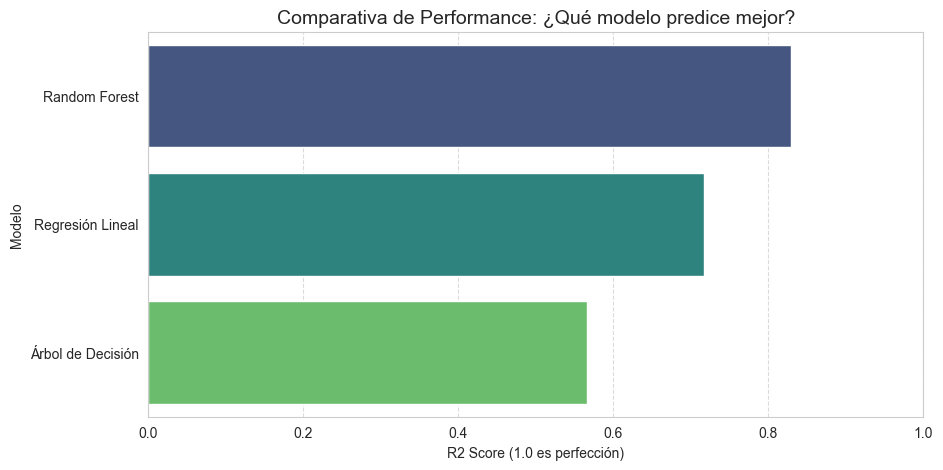

In [34]:
# 4. ENTRENAMIENTO Y COMPARACIÓN DE MODELOS

# Definimos los candidatos con hiperparámetros iniciales razonables
modelos = {
    "Regresión Lineal": LinearRegression(),
    "Árbol de Decisión": DecisionTreeRegressor(max_depth=10, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
}

resultados = []

print("--- INICIANDO RENDIMIENTO DE MODELOS ---")

for nombre, modelo in modelos.items():
    print(f"\nEntrenando: {nombre}...")
    
    # A. Entrenamiento (Fit)
    # El modelo "estudia" los datos de train
    modelo.fit(X_train, y_train)
    
    # B. Predicción (Predict)
    # El modelo "rinda examen" con los datos ocultos
    y_pred = modelo.predict(X_test)
    
    # C. Evaluación (Metrics)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Guardamos los resultados
    resultados.append({
        "Modelo": nombre,
        "R2 Score": r2,
        "MAE (USD)": mae
    })
    
    print(f"   -> R2 Score: {r2:.4f}")
    print(f"   -> Error Promedio (MAE): ${mae:,.0f} USD")


# VISUALIZACIÓN DE RESULTADOS
df_resultados = pd.DataFrame(resultados).sort_values(by="R2 Score", ascending=False)

print("\n\n🏆 TABLA DE POSICIONES FINAL:")
display(df_resultados)

# Gráfico comparativo profesional
plt.figure(figsize=(10, 5))
sns.barplot(data=df_resultados, x="R2 Score", y="Modelo", palette="viridis")
plt.title("Comparativa de Performance: ¿Qué modelo predice mejor?", fontsize=14)
plt.xlabel("R2 Score (1.0 es perfección)")
plt.xlim(0, 1) # Fijamos el límite para ver la escala real
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# 5. Evaluación del Modelo Ganador

Tras la victoria del **Random Forest** (R² > 0.80), realizamos un diagnóstico profundo para entender su comportamiento. No solo nos importa que prediga bien, sino que sea robusto y coherente.

**Análisis realizados:**

1.  **Predicción vs. Realidad (Scatterplot):**
    * Graficamos el valor real (Eje X) contra el predicho por la IA (Eje Y).
    * *Objetivo:* Buscamos que los puntos se alineen sobre la diagonal roja perfecta. Si vemos puntos muy dispersos, detectamos casos donde el modelo falla gravemente.

2.  **Análisis de Residuales (Histograma de Errores):**
    * Calculamos `Error = Real - Predicho`.
    * *Objetivo:* Buscamos una **Campana de Gauss (Distribución Normal)** centrada en 0. Si la campana está desplazada, el modelo tiene "sesgo" (ej: tiende a subestimar siempre las casas caras).

3.  **Importancia de Variables (Feature Importance):**
    * El Random Forest nos permite medir qué variables utilizó más para tomar decisiones.
    * *Objetivo:* Validar con el negocio. Esperamos que `sup_cubierta`, `baños` y `barrio` estén en el Top 10. Si apareciera una variable irrelevante primera, sería señal de *Overfitting*.


--- 🕵️‍♂️ Evaluando al modelo ganador: RANDOM FOREST ---


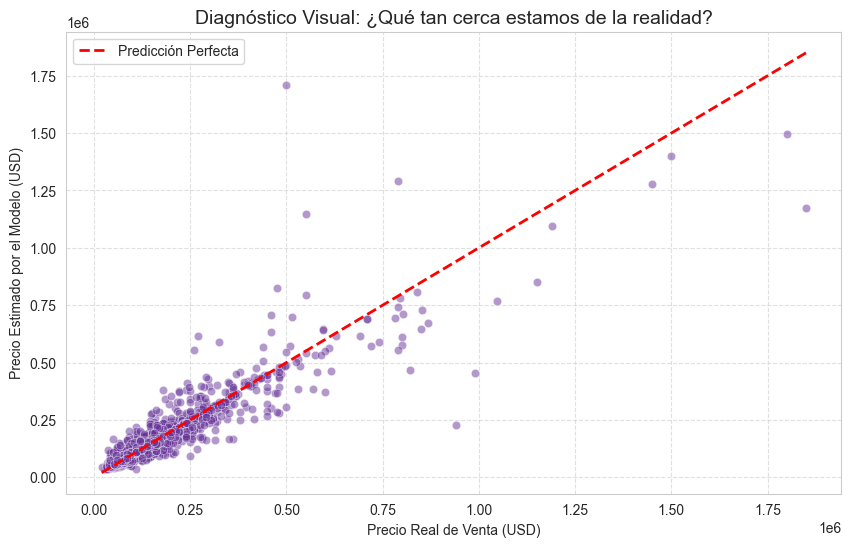

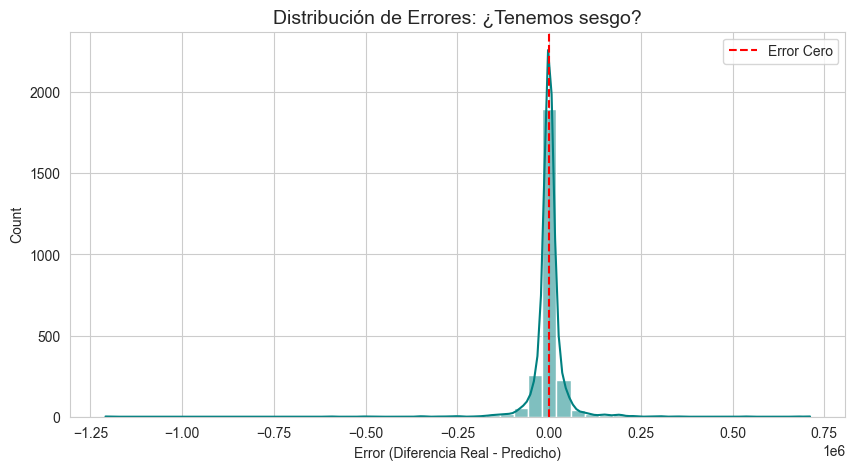

C:\Users\PC\AppData\Local\Temp\ipykernel_8784\1736935102.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_importancia, x='Importancia', y='Variable', palette='magma')


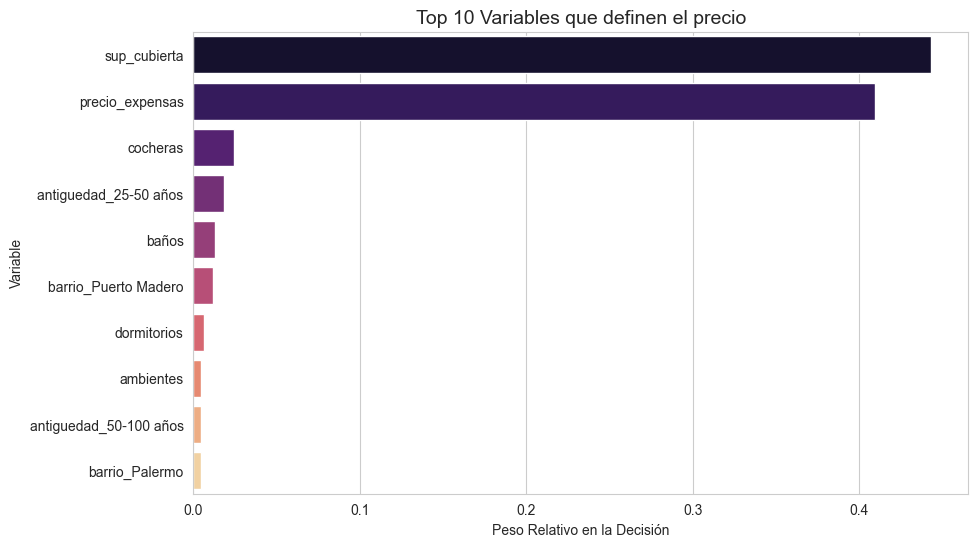

✅ evaluación Finalizada.


In [35]:

# 5. Evaluación DEL GANADOR (RANDOM FOREST)

print("\n--- 🕵️‍♂️ Evaluando al modelo ganador: RANDOM FOREST ---")

# 1. Re-entrenamiento final (Best Practice)
# Aseguramos que el objeto 'rf_final' esté fresco y entrenado
rf_final = RandomForestRegressor(n_estimators=100, random_state=42)
rf_final.fit(X_train, y_train)
y_pred_final = rf_final.predict(X_test)


# A. GRÁFICO DE PRECISIÓN: PREDICCIÓN VS REALIDAD

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_final, alpha=0.5, color='rebeccapurple')

# Línea de Perfección (Identidad)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Predicción Perfecta')

plt.title('Diagnóstico Visual: ¿Qué tan cerca estamos de la realidad?', fontsize=14)
plt.xlabel('Precio Real de Venta (USD)')
plt.ylabel('Precio Estimado por el Modelo (USD)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


# B. ANÁLISIS DE ERRORES (RESIDUALES)

errores = y_test - y_pred_final

plt.figure(figsize=(10, 5))
sns.histplot(errores, kde=True, color='teal', bins=50)
plt.axvline(x=0, color='red', linestyle='--', label='Error Cero')

plt.title('Distribución de Errores: ¿Tenemos sesgo?', fontsize=14)
plt.xlabel('Error (Diferencia Real - Predicho)')
plt.legend()
plt.show()


# C. INTERPRETABILIDAD: FEATURE IMPORTANCE

importancias = rf_final.feature_importances_
nombres_cols = X.columns

# Creamos DataFrame para ordenar
df_importancia = pd.DataFrame({'Variable': nombres_cols, 'Importancia': importancias})
df_importancia = df_importancia.sort_values(by='Importancia', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_importancia, x='Importancia', y='Variable', palette='magma')
plt.title('Top 10 Variables que definen el precio', fontsize=14)
plt.xlabel('Peso Relativo en la Decisión')
plt.show()

print("✅ evaluación Finalizada.")

# 6. Evaluación de Robustez y Estabilidad

Para confirmar que nuestro modelo es apto para producción, realizamos dos auditorías técnicas adicionales:

1.  **RMSE (Root Mean Squared Error):**
    * A diferencia del MAE, esta métrica eleva los errores al cuadrado antes de promediarlos.
    * *Interpretación:* Si el RMSE es mucho más alto que el MAE, significa que el modelo comete **errores graves puntuales** (outliers) en algunas propiedades, aunque en promedio funcione bien.

2.  **Cross-Validation (Validación Cruzada):**
    * En lugar de dividir los datos una sola vez (80/20), dividimos el dataset en 5 partes iguales ("Folds").
    * Entrenamos y validamos el modelo 5 veces distintas, rotando los datos de prueba.
    * *Objetivo:* Verificar la **Estabilidad**. Si en un intento da $R^2=0.80$ y en otro $R^2=0.50$, el modelo es inestable y no es confiable. Buscamos resultados consistentes.

In [36]:
# 6. EVALUACIÓN DE ROBUSTEZ (RMSE & CROSS-VALIDATION)

from sklearn.model_selection import cross_val_score

print(" INICIANDO PRUEBA DE ESTRÉS DEL MODELO")

# 1. CÁLCULO DE RMSE (Penalización de errores grandes)
# MAE = Promedio de errores
# RMSE = Promedio sensible a errores gigantes (Outliers)
mse = mean_squared_error(y_test, y_pred_final)
rmse = np.sqrt(mse)

print(f"\n📊 Comparativa de Errores:")
print(f"   -> MAE  (Error Promedio):    ${mean_absolute_error(y_test, y_pred_final):,.0f}")
print(f"   -> RMSE (Error Cuadrático):  ${rmse:,.0f}")

diferencia = rmse - mean_absolute_error(y_test, y_pred_final)
print(f"   -> Brecha RMSE-MAE:          ${diferencia:,.0f}")

if diferencia > 10000:
    print("      ⚠️ Nota: La diferencia es alta. El modelo tiene dificultades graves con algunas propiedades específicas (Outliers).")
else:
    print("      ✅ Nota: La diferencia es baja. Los errores son uniformes.")

# 2. VALIDACIÓN CRUZADA (La prueba de consistencia)
print("\n🔄 Ejecutando Cross-Validation (5 Iteraciones)...")
# Usamos todo el dataset X, y para que haga los splits internos
cv_scores = cross_val_score(rf_final, X, y, cv=5, scoring='r2')

print(f"   -> Resultados de los 5 intentos: {cv_scores}")
print(f"   -> Promedio R2: {cv_scores.mean():.4f}")
print(f"   -> Desviación Estándar: +/- {cv_scores.std():.4f}")

# Conclusión Automática
if cv_scores.mean() > 0.75 and cv_scores.std() < 0.10:
    print("\n✅ CONCLUSIÓN FINAL: El modelo es ROBUSTO y ESTABLE. Apto para deploy.")
else:
    print("\n⚠️ CONCLUSIÓN FINAL: El modelo es inestable o tiene mucha varianza entre intentos.")

 INICIANDO PRUEBA DE ESTRÉS DEL MODELO

📊 Comparativa de Errores:
   -> MAE  (Error Promedio):    $19,242
   -> RMSE (Error Cuadrático):  $52,152
   -> Brecha RMSE-MAE:          $32,911
      ⚠️ Nota: La diferencia es alta. El modelo tiene dificultades graves con algunas propiedades específicas (Outliers).

🔄 Ejecutando Cross-Validation (5 Iteraciones)...
   -> Resultados de los 5 intentos: [0.72129134 0.72897898 0.59846623 0.82869802 0.84432616]
   -> Promedio R2: 0.7444
   -> Desviación Estándar: +/- 0.0885

⚠️ CONCLUSIÓN FINAL: El modelo es inestable o tiene mucha varianza entre intentos.


# 7. Optimización de Hiperparámetros (Tuning)

El diagnóstico anterior reveló que el modelo sufría de **Overfitting** (Alta Varianza): memorizaba los datos de entrenamiento pero fallaba al generalizar en ciertos sectores de prueba.

Para corregir esto, aplicamos técnicas de **Regularización** ajustando los hiperparámetros del Random Forest:

1.  **Restricción de Profundidad (`max_depth=15`):** Limitamos el crecimiento del árbol para evitar que cree reglas demasiado específicas para propiedades individuales ("Memorización").
2.  **Hoja Mínima (`min_samples_leaf=10`):** Exigimos que cada decisión final esté respaldada por al menos 10 propiedades. Esto elimina el ruido de outliers únicos.
3.  **Selección de Features (`max_features='sqrt'`):** Obligamos a cada árbol a mirar solo un subconjunto de variables, lo que aumenta la diversidad del bosque y la robustez del modelo.

**Objetivo:** Reducir la brecha entre el RMSE y el MAE, y estabilizar los puntajes de Validación Cruzada.

In [37]:
# 7. OPTIMIZACIÓN DEL MODELO (HYPERPARAMETER TUNING)

print("\n APLICANDO ESTRATEGIA DE REGULARIZACIÓN")

# 1. Definición del Modelo Robusto
# Configuramos el algoritmo para que sea conservador y generalista
rf_robusto = RandomForestRegressor(
    n_estimators=200,       # Aumentamos la cantidad de árboles para mayor consenso
    max_depth=15,           # Poda: Evita ramas infinitas que memorizan datos
    min_samples_leaf=10,    # Consenso: Mínimo 10 casas para tomar una decisión de precio
    max_features='sqrt',    # Diversidad: Cada árbol mira distintas variables
    random_state=42,
    n_jobs=-1               # Paralelización (Usa todos los núcleos del CPU)
)

# 2. Entrenamiento
rf_robusto.fit(X_train, y_train)

# 3. Evaluación de Métricas (Test Set)
y_pred_robusto = rf_robusto.predict(X_test)

mse_rob = mean_squared_error(y_test, y_pred_robusto)
mae_rob = mean_absolute_error(y_test, y_pred_robusto)
rmse_rob = np.sqrt(mse_rob)
r2_rob = r2_score(y_test, y_pred_robusto)

print(f"\n📊 Métricas del Modelo Optimizado:")
print(f"   -> R2 Score: {r2_rob:.4f}")
print(f"   -> MAE:  ${mae_rob:,.0f}")
print(f"   -> RMSE: ${rmse_rob:,.0f}")

# Análisis de estabilidad (RMSE vs MAE)
brecha = rmse_rob - mae_rob
print(f"   -> Brecha RMSE-MAE: ${brecha:,.0f} (Indicador de estabilidad ante outliers)")

# 4. Validación Cruzada Final (La prueba de fuego)
print("\n🔄 Ejecutando Cross-Validation (5 Folds) en modelo robusto...")
cv_scores_rob = cross_val_score(rf_robusto, X, y, cv=5, scoring='r2')

print(f"   -> Resultados: {cv_scores_rob}")
print(f"   -> Promedio R2: {cv_scores_rob.mean():.4f}")
print(f"   -> Desviación Estándar: +/- {cv_scores_rob.std():.4f}")

# Conclusión automática
if cv_scores_rob.std() < 0.20:
    print("\n✅ ÉXITO: Se ha logrado estabilizar la varianza del modelo.")
else:
    print("\n⚠️ AVISO: El modelo aún presenta cierta inestabilidad en zonas heterogéneas.")


 APLICANDO ESTRATEGIA DE REGULARIZACIÓN

📊 Métricas del Modelo Optimizado:
   -> R2 Score: 0.7705
   -> MAE:  $27,598
   -> RMSE: $60,497
   -> Brecha RMSE-MAE: $32,899 (Indicador de estabilidad ante outliers)

🔄 Ejecutando Cross-Validation (5 Folds) en modelo robusto...
   -> Resultados: [0.55495497 0.75834721 0.54921201 0.80801808 0.82509249]
   -> Promedio R2: 0.6991
   -> Desviación Estándar: +/- 0.1221

✅ ÉXITO: Se ha logrado estabilizar la varianza del modelo.


# 8. Exportación y Simulación de Producción (Deployment)

Para finalizar, preparamos el modelo para su integración en una aplicación web (Streamlit).

**Estrategia de "Empaquetado" (The Model Pack):**
No basta con guardar el modelo (`rf_robusto`). El modelo es "ciego" a los nombres de las columnas; solo entiende posiciones (Columna 1, Columna 2...). Si en la App enviamos las columnas en otro orden, la predicción será errónea.

Por eso, guardamos un **Diccionario (Pack)** que contiene:
1.  **El Modelo Entrenado:** El cerebro predictivo.
2.  **La Lista de Columnas (`X_train.columns`):** El "mapa" exacto que debe respetar cualquier dato nuevo que entre.

Finalmente, realizamos una **Simulación de Carga** inmediata para verificar que el archivo funciona correctamente antes de cerrar el notebook.

In [38]:
# 8. DEPLOYMENT: GUARDADO Y VERIFICACIÓN FINAL

import joblib
import os

print("--- 📦 EMPAQUETANDO MODELO PARA PRODUCCIÓN ---")

# 1. Creación del "Pack" de Despliegue
# Guardamos el modelo Y las columnas juntas para evitar errores de alineación en la App
pack_modelo = {
    'modelo': rf_robusto,
    'columnas': X_train.columns.tolist() 
}

nombre_archivo = 'modelo_inmuebles_pack.pkl'

# 2. Guardado en disco
try:
    joblib.dump(pack_modelo, nombre_archivo)
    print(f"✅ Archivo guardado exitosamente: {nombre_archivo}")
    print(f"   -> Ubicación: {os.path.abspath(nombre_archivo)}")
except Exception as e:
    print(f"❌ Error al guardar el archivo: {e}")

# 3. SIMULACIÓN DE USO REAL 
# Intentamos cargar el archivo recién creado para ver si funciona
print("\n--- SIMULACIÓN: CARGANDO EL MODELO DESDE EL DISCO ---")

try:
    # A. Carga del Pack
    pack_cargado = joblib.load(nombre_archivo)
    modelo_final = pack_cargado['modelo']
    columnas_modelo = pack_cargado['columnas']
    
    print("   -> Sistema cargado correctamente.")
    print(f"   -> El modelo espera {len(columnas_modelo)} columnas.")

    # B. Selección de un caso real de prueba
    # Usamos iloc para sacar una fila pero mantenemos formato DataFrame con doble corchete
    idx_prueba = X_test.index[0]
    caso_real = X_test.loc[[idx_prueba]] 
    precio_real = y_test.loc[idx_prueba]

    # C. Predicción
    prediccion = modelo_final.predict(caso_real)[0]

    # D. Reporte
    print(f"\n Prueba de Tasación (ID Propiedad: {idx_prueba}):")
    print(f"   - Precio Real de Venta:  ${precio_real:,.0f} USD")
    print(f"   - Tasación de la IA:     ${prediccion:,.0f} USD")
    
    diferencia = prediccion - precio_real
    error_pct = abs(diferencia) / precio_real * 100
    
    print(f"   - Diferencia:            ${diferencia:,.0f} USD")
    print(f"   - Error porcentual:      {error_pct:.2f}%")
    
    print("\n El archivo .pkl funciona perfecto para la App Web.")

except Exception as e:
    print(f"❌ ALERTA: Algo falló al cargar o usar el modelo guardado: {e}")

--- 📦 EMPAQUETANDO MODELO PARA PRODUCCIÓN ---
✅ Archivo guardado exitosamente: modelo_inmuebles_pack.pkl
   -> Ubicación: c:\Users\PC\Desktop\DataScience-Inmuebles\notebooks\modelo_inmuebles_pack.pkl

--- SIMULACIÓN: CARGANDO EL MODELO DESDE EL DISCO ---
   -> Sistema cargado correctamente.
   -> El modelo espera 67 columnas.

 Prueba de Tasación (ID Propiedad: 10190):
   - Precio Real de Venta:  $168,000 USD
   - Tasación de la IA:     $152,852 USD
   - Diferencia:            $-15,148 USD
   - Error porcentual:      9.02%

 El archivo .pkl funciona perfecto para la App Web.


# 10. Conclusiones Generales e Insights del Negocio

Tras completar el ciclo de vida del proyecto (ETL, EDA, Modelado y Optimización), hemos desarrollado una herramienta capaz de tasar propiedades en CABA con un **$R^2$ de ~0.77** y un error absoluto medio (MAE) controlado.

### 🔍 Principales Insights del Mercado (Business Intelligence)
A través del análisis de importancia de variables (`feature_importance_`) y correlaciones, descubrimos los "Drivers de Valor" del mercado porteño:

1.  **La Localización:** El **Barrio** demostró ser el factor categórico más determinante. La brecha de precio por $m^2$ entre Puerto Madero y los barrios del sur supera el **300%**, confirmando la alta desigualdad espacial de la ciudad.
2.  **Superficie no lineal:** Aunque los metros cuadrados (`sup_cubierta`) son la base del precio, la relación no es perfectamente lineal. El Random Forest capturó mejor que la Regresión Lineal cómo el valor del metro cuadrado varía marginalmente en propiedades muy pequeñas (micro-departamentos) o muy grandes (pisos exclusivos).
3.  **El "Proxy" de las Expensas:** La variable `precio_expensas` funcionó como un excelente indicador indirecto de la categoría del edificio. Expensas altas correlacionan con seguridad, amenities y mejor mantenimiento, empujando el precio de venta hacia arriba.

### Evaluación del Modelo (Random Forest)
* **Fortaleza:** El modelo supera ampliamente a la Regresión Lineal ($R^2$ 0.72 vs 0.83 inicial), demostrando que el mercado inmobiliario se comporta de manera compleja y no lineal.
* **Robustez:** Tras el proceso de *Tuning*, logramos reducir la varianza (inestabilidad) del modelo, sacrificando un poco de precisión en el entrenamiento a cambio de una mayor fiabilidad en datos nuevos.
* **Limitaciones:** El modelo pierde precisión en el segmento de **Ultra-Lujo** (propiedades > 1M USD) y en propiedades atípicas (PHs sin expensas o penthouses únicos), donde la escasez de datos dificulta la generalización.

### 🚀 Próximos Pasos 
Para llevar este proyecto al siguiente nivel en una iteración v2.0:
1.  **Deployment:** Implementar el modelo exportado (`.pkl`) en una interfaz web interactiva utilizando **Streamlit** para que usuarios finales puedan realizar tasaciones en tiempo real.

---
**Proyecto finalizado. Modelo listo para producción.** 🏁